# FatTailedTools: Examples

This notebook is meant to demonstrate the use of the various functions. As **case**, we will use the daily prices of the S&P500 index between 1950 and 2022. This case is in accordance to what is shown in the chapter *"It is what it is": Diagnosing the SP500* in the book *Statistical Consequences of Fat Tails* by Nassim N. Taleb, 2020. The data can, for example, be found on Yahoo Finance.

## 0. Load Data

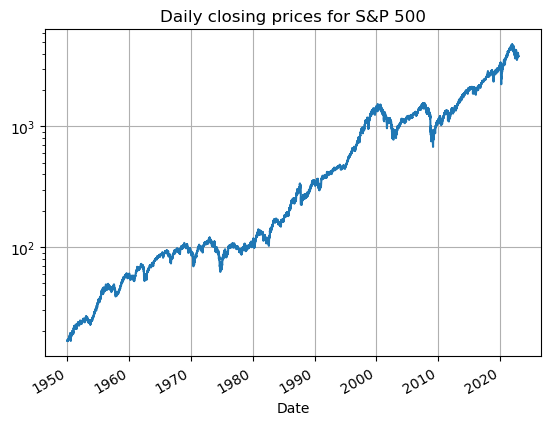

In [75]:
import matplotlib.pyplot as plt
import pandas as pd

# Read daily prices of S&P500 from csv file
df = pd.read_csv(
    r'C:\Users\sevsad\OneDrive - SINTEF\Knowlegde Building\Friday Challenges\SP500.csv',
    index_col=[0], usecols=['Date', 'Close']
)

# Make sure the data is sorted
df.sort_index(inplace=True, ascending=True)

# Convert index to DateTimeIndex
df.index = pd.to_datetime(df.index)

# Use data between 1950 and 2022
series = df.loc['1950-01-01':'2022-12-31', 'Close'].dropna()

# Visualize
series.plot(logy=True, grid=True, title='Daily closing prices for S&P 500');

## 1. Calculate Log Returns

In [76]:
from FatTailedTools import returns, tails

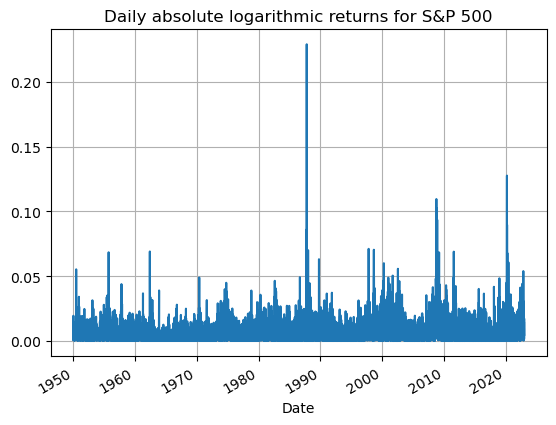

In [77]:
# Get logarithmic returns from daily closing prices of the S&P500 between 1950 and 2022
log_returns = returns.get_log_returns(series=series)

# Get absolute returns
log_returns_abs = tails.get_both_tails(series=log_returns)

# Get returns for left and right tails separately
log_returns_left  = tails.get_left_tail(series=log_returns)
log_returns_right = tails.get_right_tail(series=log_returns)

# Visualize
log_returns_abs.plot(grid=True, title='Daily absolute logarithmic returns for S&P 500');

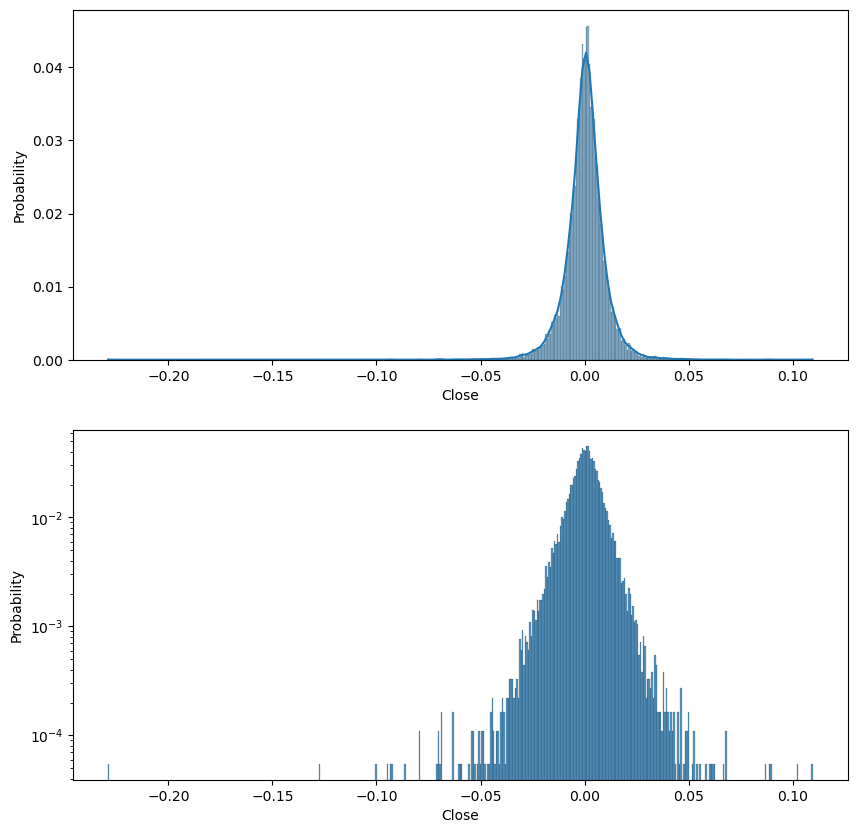

In [78]:
from FatTailedTools import plotting

# Plot a histogram
plotting.plot_histograms(series=log_returns)

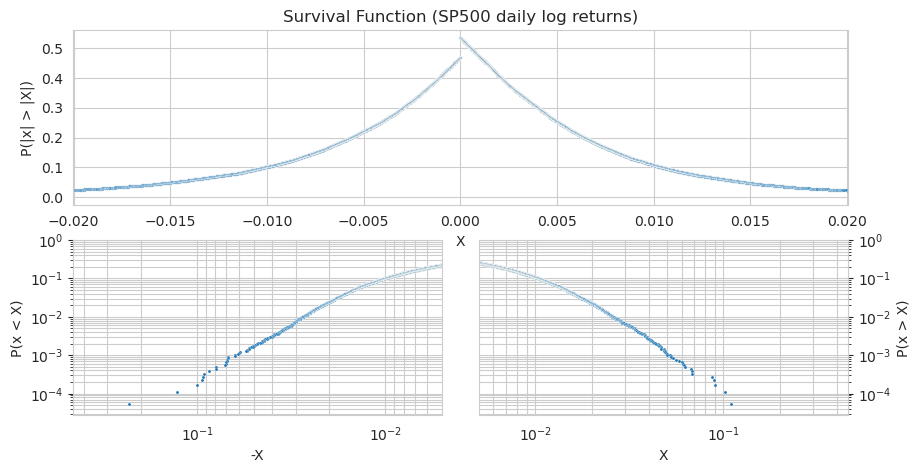

In [79]:
# Plot a two-sided survival function which shows the probability to exceed a threshold for left and right tails
plotting.plot_twosided_survival_function(series=log_returns, title_annotation='SP500 daily log returns');

## 2. Visual Identification of Paretianity

In [80]:
from FatTailedTools import alpha

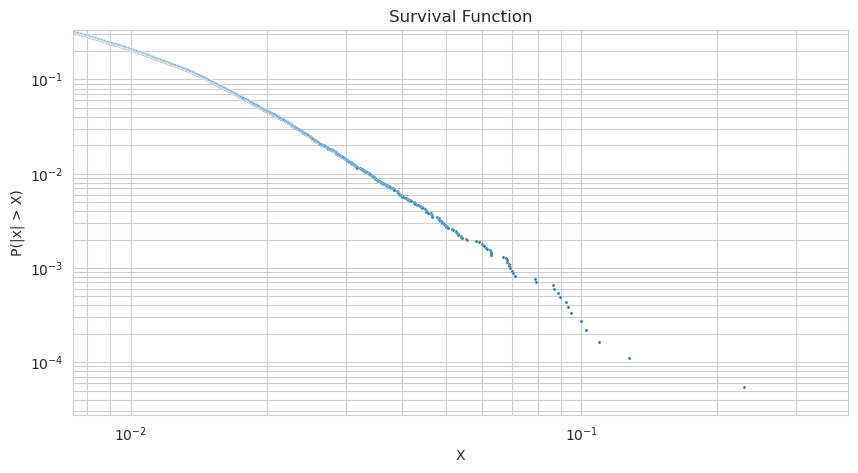

In [81]:
# Plot survival function for absolute returns.
# The huge "outlier" is Black Monday in 1987.
plotting.plot_survival_function(series=log_returns_abs, tail_zoom=True);

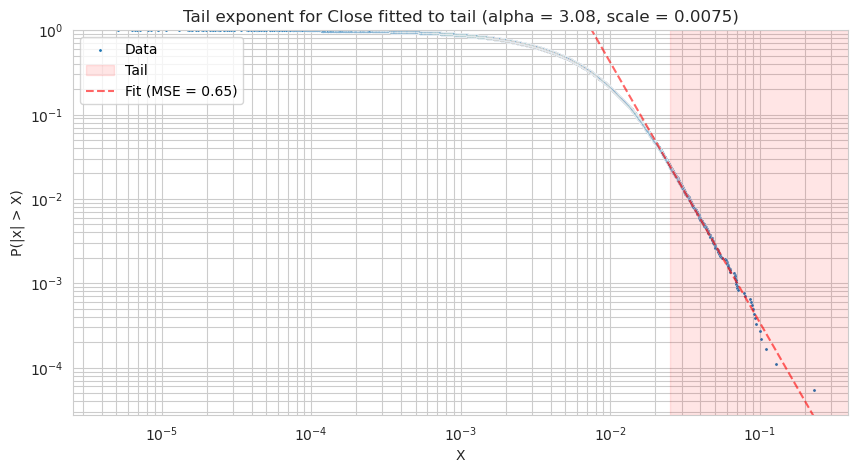

In [82]:
# Based on a first quick look, the tail of the absolute returns seems to be well approximated by a Pareto
# distribution with tail exponent around 3 and scale of around 0.0075:
alpha.fit_alpha_linear(series=log_returns_abs, tail_frac=(log_returns_abs >= 0.025).mean());

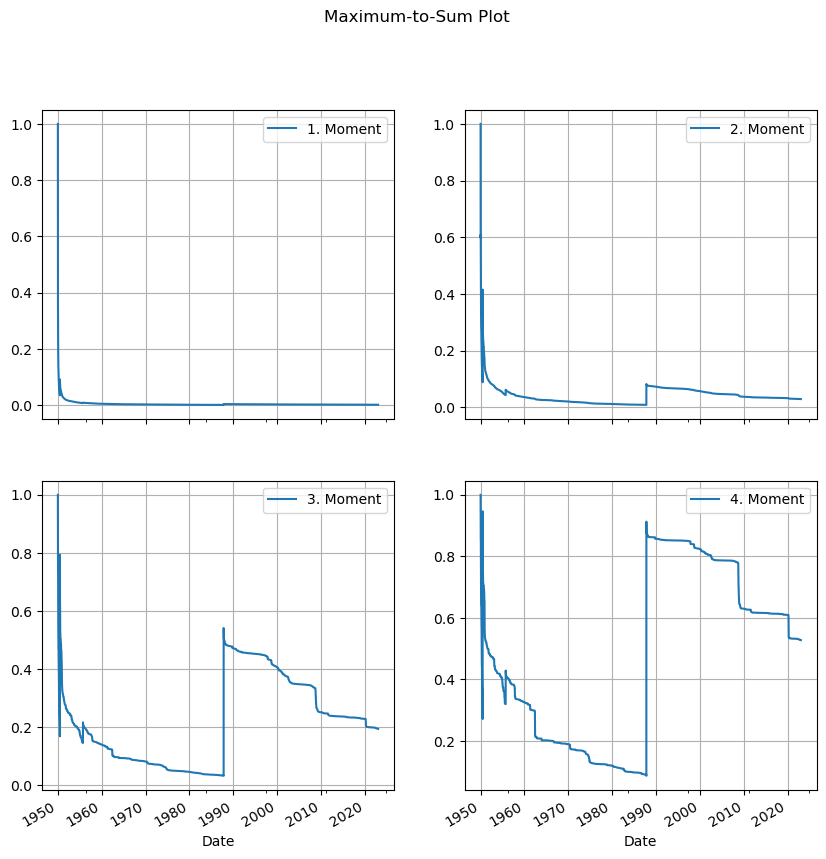

In [83]:
# Plot maximum-to-sum plot for the first 4 moments of the absolute log returns
# The 4. moment clearly does not converge, indicating the non-existence of the fourth moment.
plotting.max_sum_plot(series=log_returns_abs)

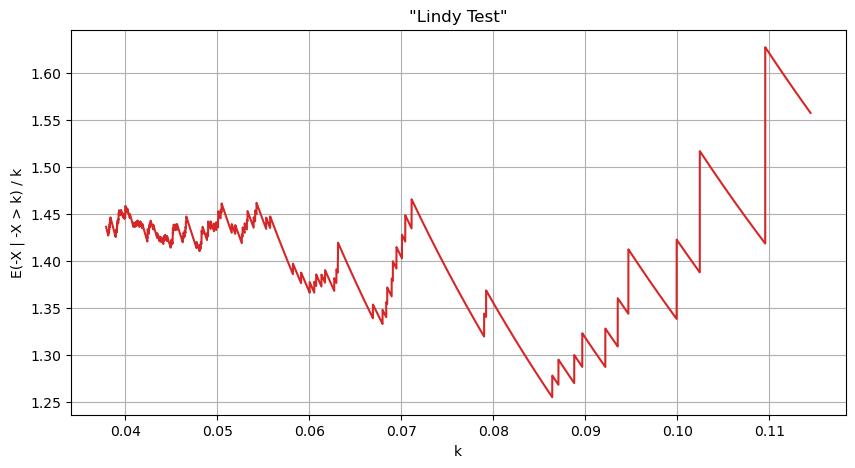

In [84]:
# The Lindy test or conditional expectation below a threshold k.
# As we increase k, the measure should drop. Yet it clearly does not.
plotting.plot_lindy_test(series=log_returns_abs)

(3.060008001472262, 0.0005102478006376505, 0.00617610176678113)

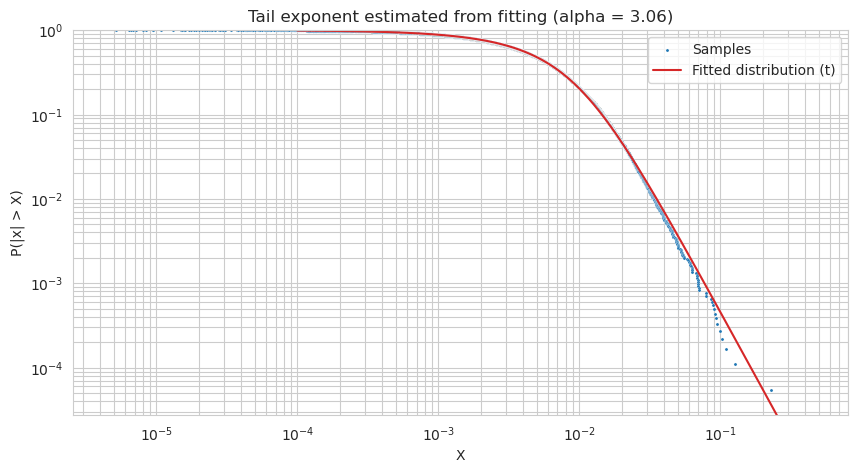

In [85]:
# The data could fit a Student's t with tail exponent (degrees of freedom) of around 3.
alpha.fit_alpha(series=log_returns, return_additional_params=True)

## 3. Max Drawdowns

In [32]:
# Calculate max (logarithmic) drawdowns for 5, 30, 100, and 252 days

max_drawdowns = {}
periods = ['7d', '45d', '150d', '365d']

for period in periods:
    max_drawdowns.update({
        period: returns.get_max_drawdowns(series=series, periods=period, use_log=True)
    })

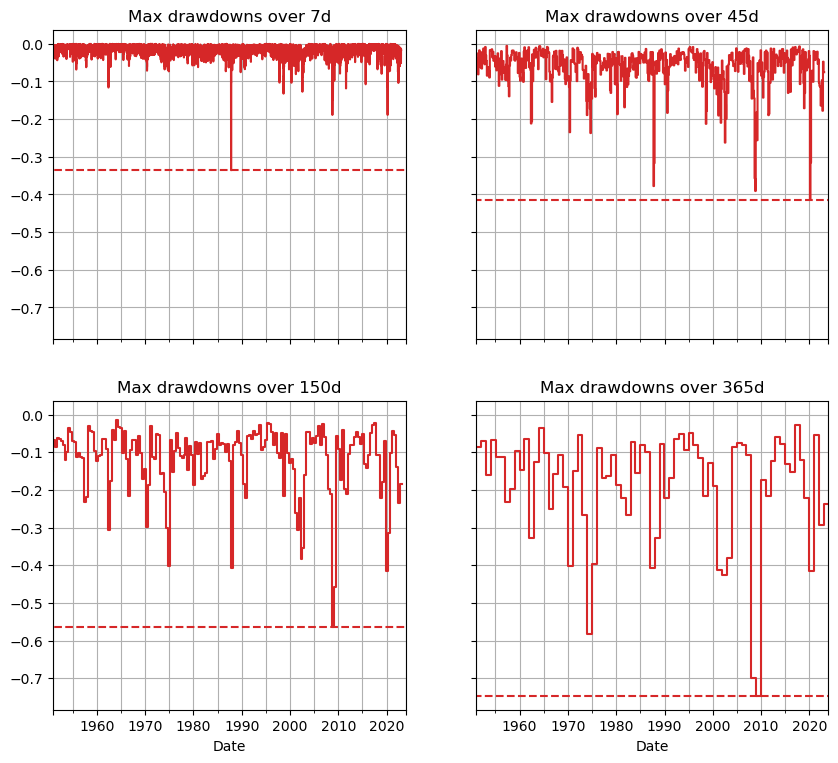

In [33]:
# Visualize
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplot_mosaic(np.array(periods).reshape(2,-1), sharex=True, sharey=True, figsize=(10, 10))

for key, item in max_drawdowns.items():

    max_drawdowns[key].plot(drawstyle='steps', color='C3', ax=ax[key]);
    ax[key].axhline(max_drawdowns[key].min(), *ax[key].get_xlim(), color='C3', linestyle='--');
    ax[key].grid(which='both');
    ax[key].set_title('Max drawdowns over {}'.format(key));

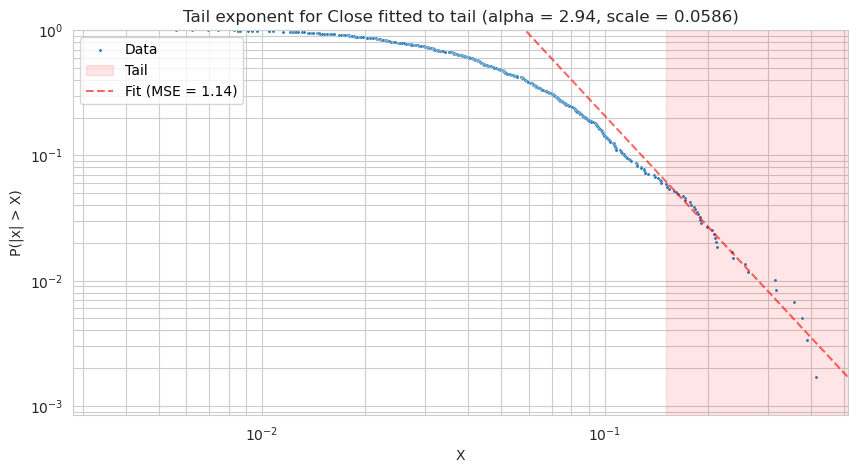

In [36]:
# Plot survival function for max drawdowns for 45d (30 trading days)
alpha.fit_alpha_linear(series=max_drawdowns['45d'], tail_frac=(max_drawdowns['45d'] <= -0.15).mean());

## 4. Empirical Kappa

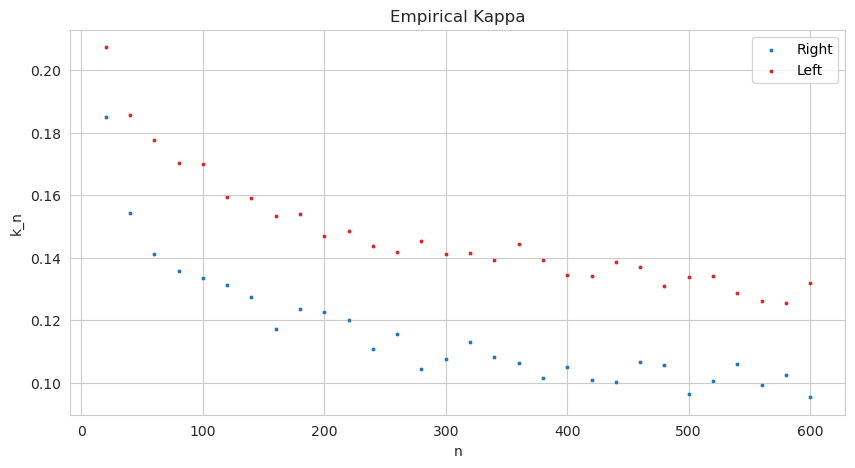

In [37]:
plotting.plot_empirical_kappa_n(series=log_returns, n_bootstrapping=100000)

## 5. Gumbel Test

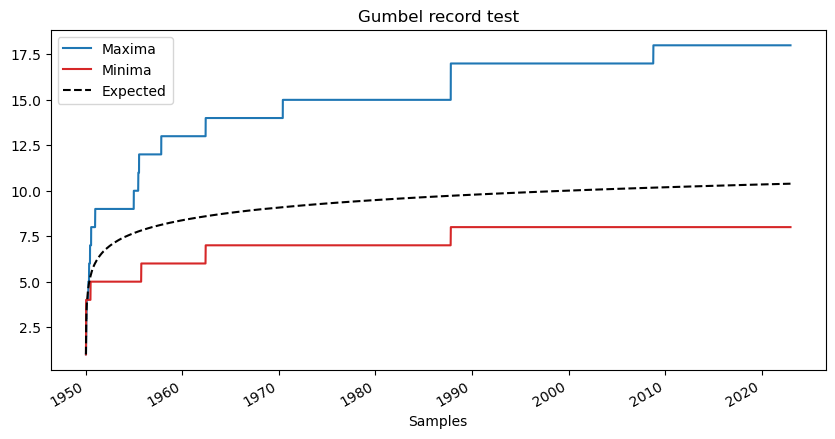

In [38]:
plotting.plot_gumbel_test(series=log_returns)

## 6. Estimating Tail Exponent

### 6.1 Absolute daily (log) returns

C:\Repos\OptionTradingFramework\FatTailedTools\plotting.py:286: UserWarning: Hill estimator temporarily deactivated due to a potential bug in the calculations.
  warnings.warn('Hill estimator temporarily deactivated due to a potential bug in the calculations.')


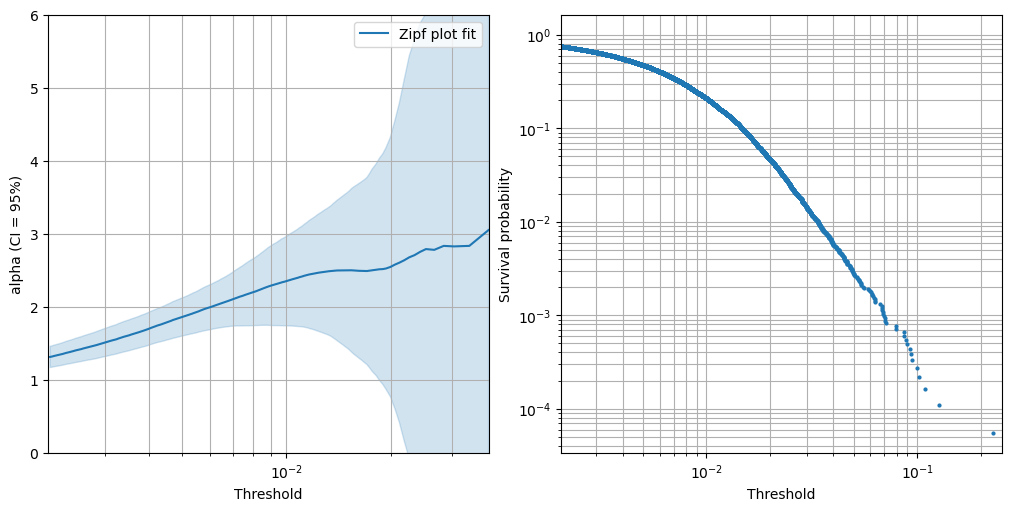

In [39]:
# Visual estimation of tail exponent by varying the assumed tail start
plotting.graphical_alpha_estimation(series=log_returns_abs)

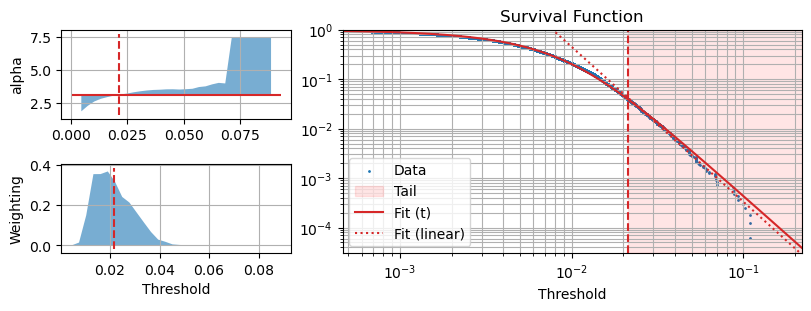

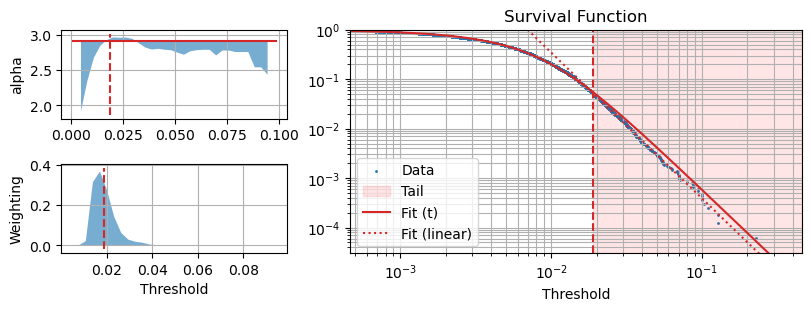

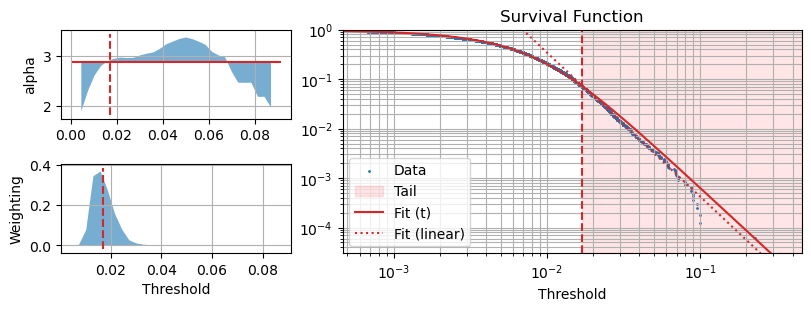

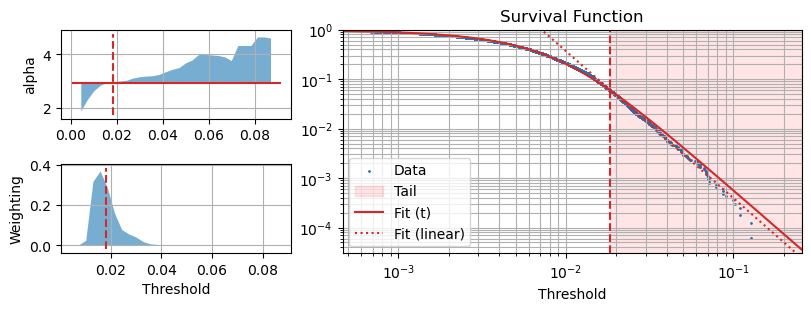

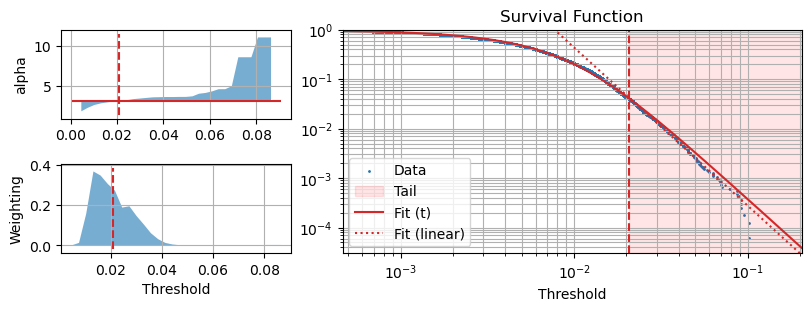

0.006185139836008024 0.3270600314843328


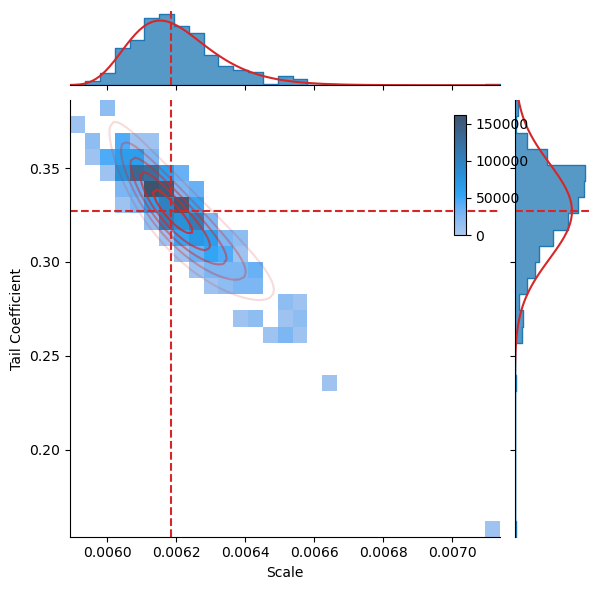

In [40]:
# We can also try to include all sources of uncertainty (via sample bootstrapping and varying the threshold
# beyond which samples are used for the linear MSE fit on the tail in a log-log survival plot.
# The tail exponent is estimated to slightly above 3.
alpha.fit_alpha_and_scale_linear_subsampling(
    data          = series,
    period_days   = 1,
    tail          = 'both',
    n_debug_plots = 5
);

### 6.2 Max drawdowns 150 days

C:\Repos\OptionTradingFramework\FatTailedTools\plotting.py:286: UserWarning: Hill estimator temporarily deactivated due to a potential bug in the calculations.
  warnings.warn('Hill estimator temporarily deactivated due to a potential bug in the calculations.')


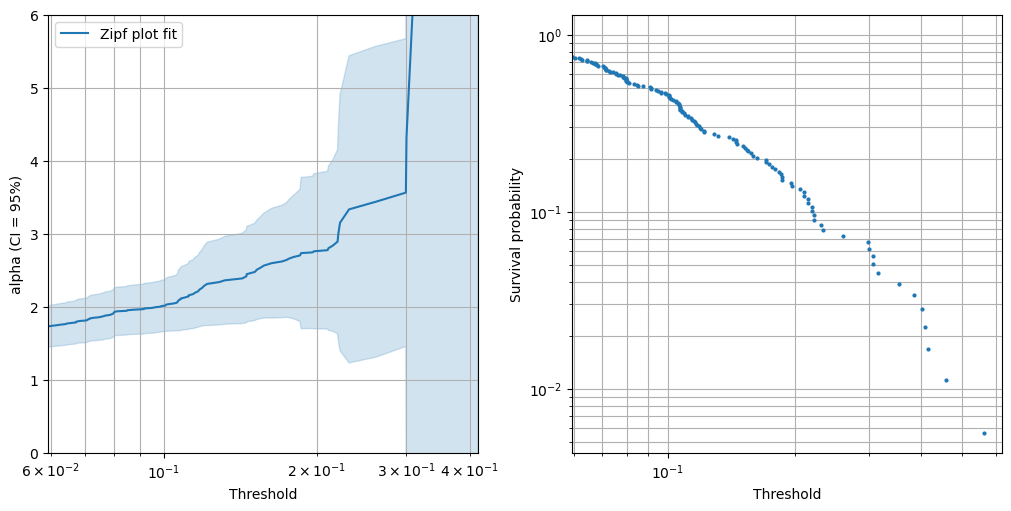

In [41]:
# Visual estimation of tail exponent by varying the assumed tail start
plotting.graphical_alpha_estimation(series=max_drawdowns['150d']);

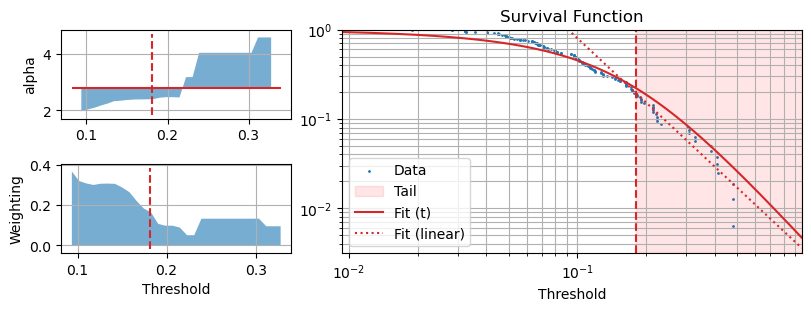

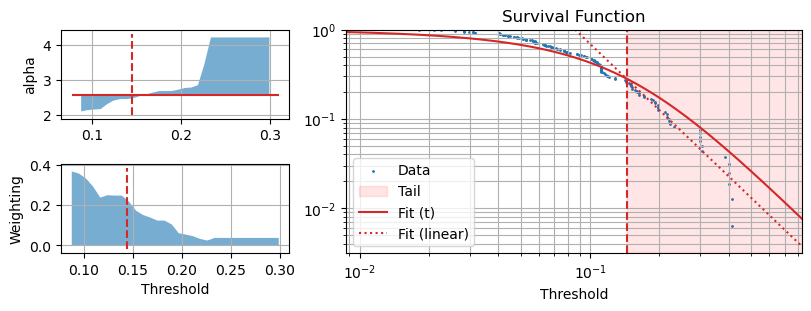

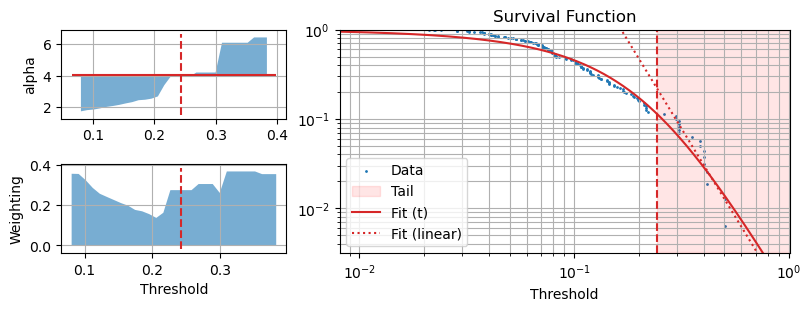

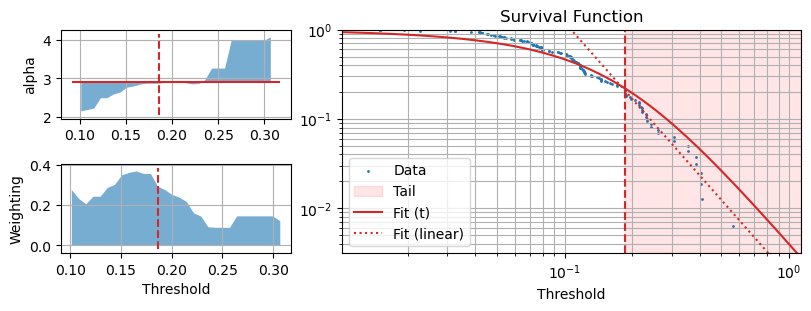

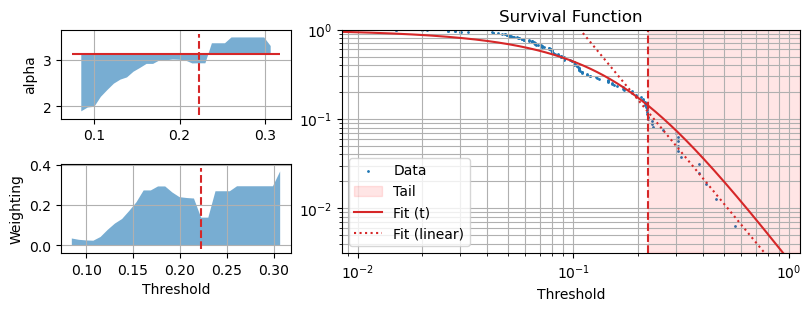

0.10844225876227011 0.36353800102970446


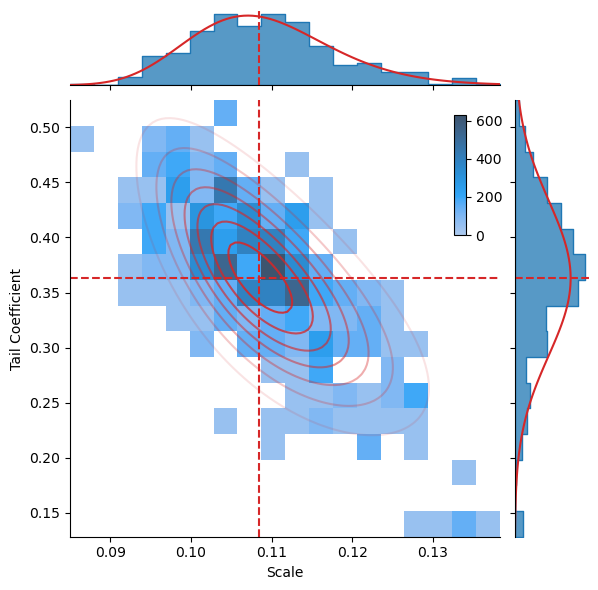

In [42]:
# Proper treatment including all uncertainty we can handle:
# In the data (bootstrapping), which intervals to take when calculating draws over 150 days (time offset),
# and uncertainty wrt. where the tail starts.
# Tail exponent is estimated to around 2.6
alpha.fit_alpha_and_scale_linear_subsampling(
    data                = series,
    period_days         = 150,
    tail                = 'left',
    transformation_func = returns.get_max_drawdowns,
    n_debug_plots       = 5
);

## 7. Fitting Log Returns to a Student's t distribution

In [86]:
from scipy.stats import t

### 7.1 Symmetric Student's t

In [87]:
# Fit to Student's t
dist = t
dist_params = dist.fit(log_returns.dropna())

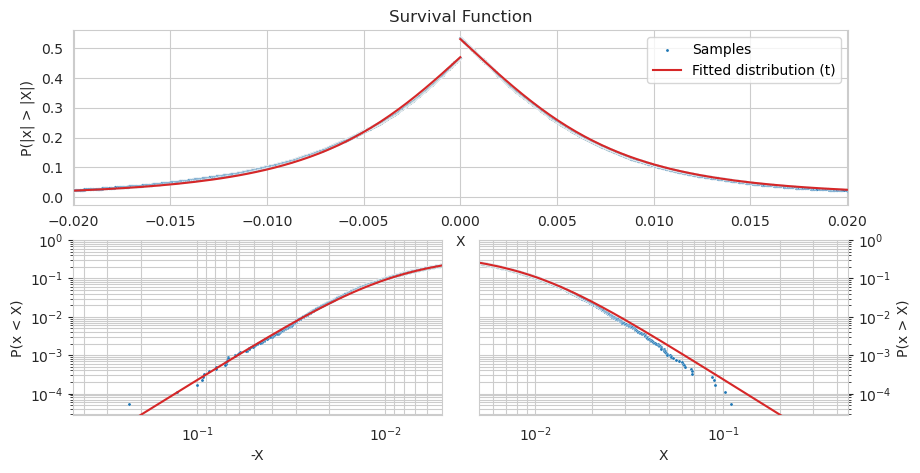

In [88]:
# Check visually
plotting.plot_twosided_survival_function(series=log_returns, distribution=(dist, dist_params));

### 7.2 Symmetric Student's t with Tail Exponent Predefined

0.006169815871080854 0.32892728397633064


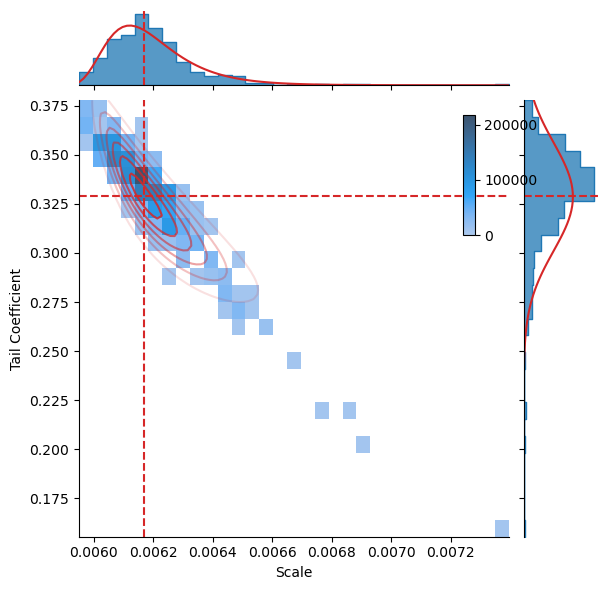

In [89]:
# Get tail exponent from subsampling routine
alpha_both, scale_both, _, _ = alpha.fit_alpha_and_scale_linear_subsampling(data=series, period_days=1, tail='both')

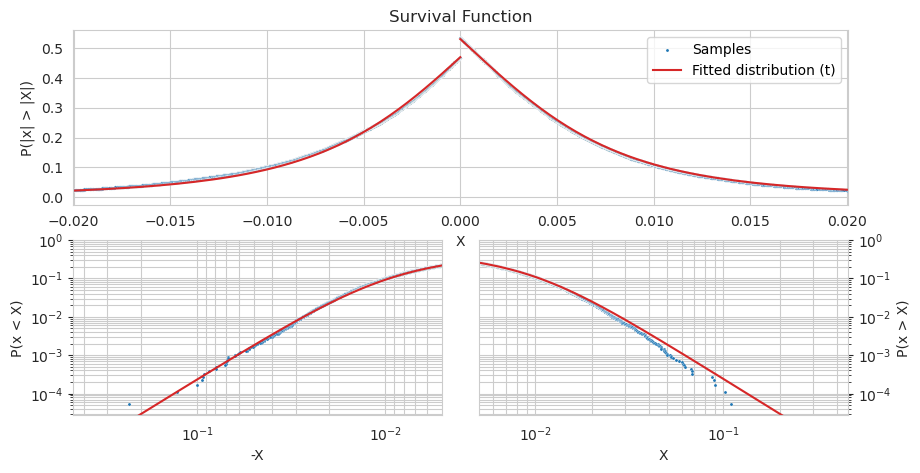

In [90]:
# Fit to Student's t, keeping tail exponent alpha and scale fixed
dist = t
dist_params = dist.fit(log_returns.dropna(), f0=alpha_both, fscale=scale_both)

# Check visually
plotting.plot_twosided_survival_function(series=log_returns, distribution=(dist, dist_params));

### 7.3 Asymmetric Student's t

0.006122486924696097 0.35871579275773957


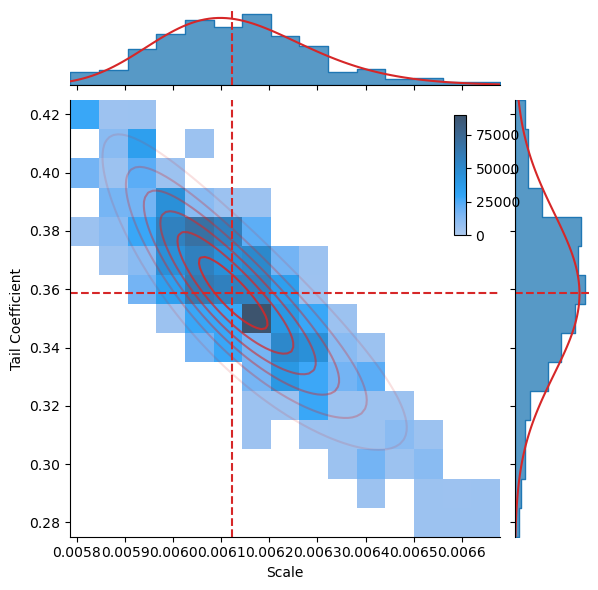

0.006164122842366964 0.31556189835918147


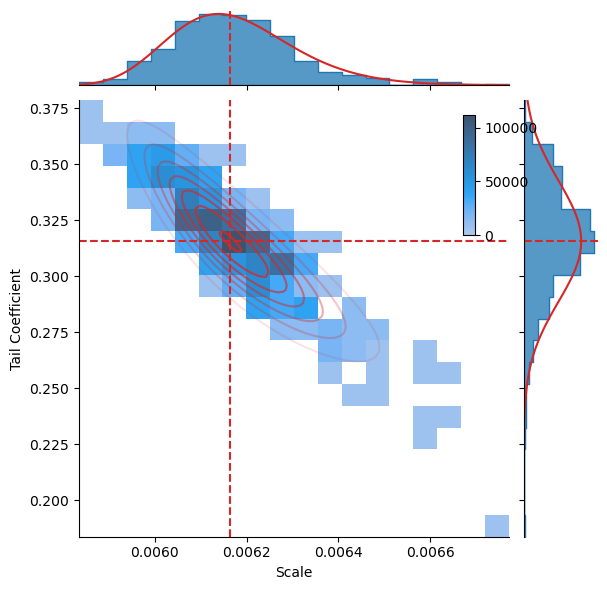

In [91]:
# Get tail exponent from subsampling routine for left and right tails separately
alpha_left,  scale_left, _, _  = alpha.fit_alpha_and_scale_linear_subsampling(data=series, period_days=1, tail='left')
alpha_right, scale_right, _, _ = alpha.fit_alpha_and_scale_linear_subsampling(data=series, period_days=1, tail='right')

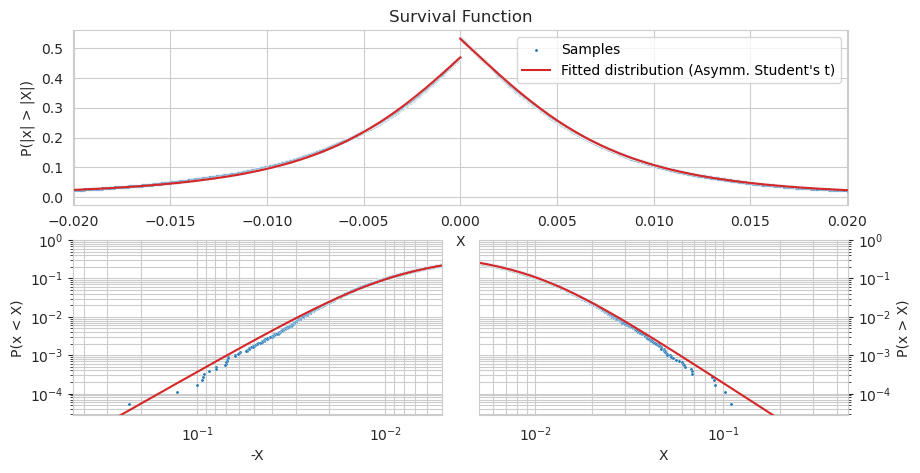

In [92]:
from FatTailedTools.distributions import JointDistribution

# Assemble asymmetric Student's t distribution
dist_middle = log_returns.dropna().median()
dist = JointDistribution(
    dist_left  = t(alpha_left,  dist_middle, scale_left),
    dist_right = t(alpha_right, dist_middle, scale_right)
)
dist_params = dist.fit(log_returns.dropna())

# Check visually
plotting.plot_twosided_survival_function(series=log_returns, distribution=(dist, dist_params));

In [93]:
(alpha_left, alpha_right)

(2.7877222586499135, 3.1689503872288527)